In [1]:
import numpy as np
import matplotlib.pyplot as plt
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier
# Gradient Boosting 
from sklearn.ensemble import GradientBoostingClassifier

plt.rcParams['font.size'] = 14

from keras.models import Sequential
from keras.layers import Dense, Dropout     # Dropout inactivate some neurons on the network
import tensorflow as tf

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
# from scikeras.wrappers import KerasClassifier to avoid DeprecationWarning from TensorFlow

import matplotlib as mpl
import matplotlib.cm as cm
mpl.rc('image', cmap='copper')

In [2]:
# XGBoost 
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance, to_graphviz, plot_tree
print("XGBoost version:",xgboost.__version__)

XGBoost version: 1.7.5


In [3]:
def data(CASE):

    np.random.seed(123)

    # Size of the grid
    global S
    
    # size of each sample
    L = 2

    # box size
    B = 100

    if CASE == 0: # Old data
        # Size of the grid
        S = 1

        # number of data
        N = 4000
        N_train = int(N*80/100)
        N_test  = N - N_train

        def f(x):
            r=0
            if x[0]>-25 and x[1]>-35 and x[0]+x[1] < 30:
                r=1
            if x[0]+x[1] > 50:
                r=1
            return r

        x,y = (np.random.random((N,2))-0.5)*B, np.zeros(N)  # generate random data
        for i in range(N):
            # label data according to a nonlinear function "f"
            y[i] = int(f(x[i]))
            
        # just to rescale a work with smaller numbers (optional), as in class
        def simple_rescaling(z):
            return z/50

        x = simple_rescaling(x)

    else:
        # Size of the grid
        S = 2

        # number of data
        N = 2000
        N_train = 1800
        N_test  = N - N_train

        x = S*(2*np.random.rand(N,2)-1)
        y = np.zeros(N).astype(int)

        for n in range(N):
            if CASE==1:
                if x[n,1]<-0.6 and x[n,0]>-0.2: y[n]=1
                if x[n,1]>0.4 and x[n,0]<-0.8: y[n]=1
                if x[n,1]>1.0 and x[n,0]>0.8: y[n]=1
            elif CASE==2:
                if x[n,1]<0 and x[n,0]>0.5: y[n]=1
                if x[n,1]>0 and np.sqrt((x[n,0]+0.3)**2+x[n,1]**2)<1.5: y[n]=1


    x_train,y_train = x[:N_train],y[:N_train]
    x_test,y_test = x[N_train:],y[N_train:]
    return x_train, x_test, y_train, y_test, N_train

In [4]:
x_train, x_test, y_train, y_test, N_train = data(1)

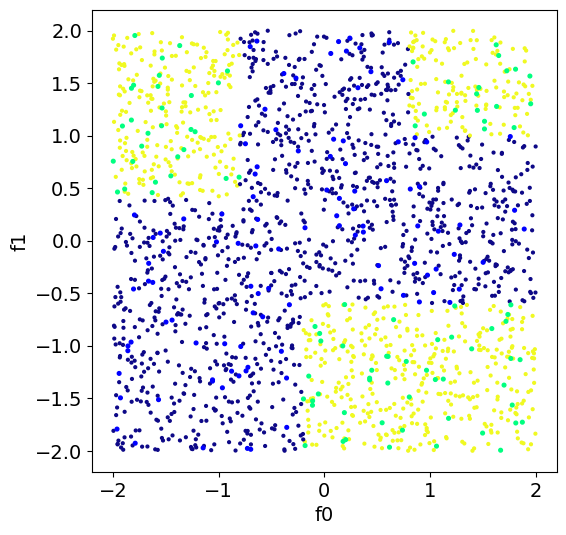

In [5]:
def scat(x,y,s=4,cmap="plasma"):
    plt.scatter(x[:,0],x[:,1],s=s,c=y,cmap=cmap)
    plt.xlabel("f0")
    plt.ylabel("f1")

plt.figure(figsize=(6,6))
scat(x_train,y_train)
scat(x_test,y_test,cmap="winter",s=7)
plt.show()

In [6]:
def classify(clf=GradientBoostingClassifier(),show=False, num=N_train, CASE=1):
    x_train, x_test, y_train, y_test, N_train = data(CASE=CASE)
    ind = [i for i in range(num)]
    np.random.shuffle(ind)
    x_train = x_train[ind]
    y_train = y_train[ind]
    clf.fit(x_train[:num], y_train[:num])
    y_hat = clf.predict(x_test)
    err = 100*(1-clf.score(x_test, y_test))
    if CASE<10: print("errors: {:.2f}%".format(err))

    dx = 0.02
    x_seq=np.arange(-S,S+dx,dx)
    nx = len(x_seq)
    x_plot=np.zeros((nx*nx,2))
    q=0
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:] = [x_seq[i],x_seq[j]]
            q+=1
    y_plot= clf.predict(x_plot)

    plt.figure(figsize=(6,6))
    title = str(clf.__class__).split(".")[-1].split("'")[0]
    title += f" N_train = {num}"
    plt.title(title)

    scat(x_plot,y_plot,cmap="winter",s=1)
    scat(x_train,y_train,s=7)
    plt.show()
    
    if show:      
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=",num_trees)
        
        fig, AX = plt.subplots(int(min(3,num_trees)),1,figsize=(30, 30))
        for i in range(min(3,num_trees)):
            if int(min(3,num_trees)) > 1:
                ax=AX[i]
            else:
                ax = AX
            plot_tree(clf, num_trees=i, ax=ax)
        fig.savefig("DATA/tree-classif.png", dpi=300, pad_inches=0.02)   
        plt.show()

    if num:
        return err

In [7]:
# Dimension of each datum
L = 2

# Number of epochs
epochs = 200

# Batch size
batch_size = 50

# 1.
## FFNN vs XGBoost
### We compare the performances of a Feed Forward Neural Network with those of a XGBoost model with decision trees. For the FFNN, we choose the best architecture previously found in the E1 homework: **optimizer = Nadam**, **activation = elu**. 
### We implemented (CASE = 0) the data set of the first homework and (CASE = 1) teh data set presented in class. The latter case is the one on which we focus more and XGBoost easily outperforms the NN with just a small number of trees, here set to 3. However, this is because the data is separated only by horizontal and vertical lines.
### We varied the number of samples in the training set, by keeping fixed the test set size. We show the *score vs $N_{train}$* relation in a simple plot.  

#### Here we train the NN on the data

C:\Users\ricta\AppData\Local\Temp\ipykernel_27608\1230038626.py:23: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  err = classify(KerasClassifier(build_fn=compile_model, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0),show=False, num=i)


7/7 [==============================] - 0s 4ms/step
errors: 25.00%
1263/1263 [==============================] - 3s 2ms/step


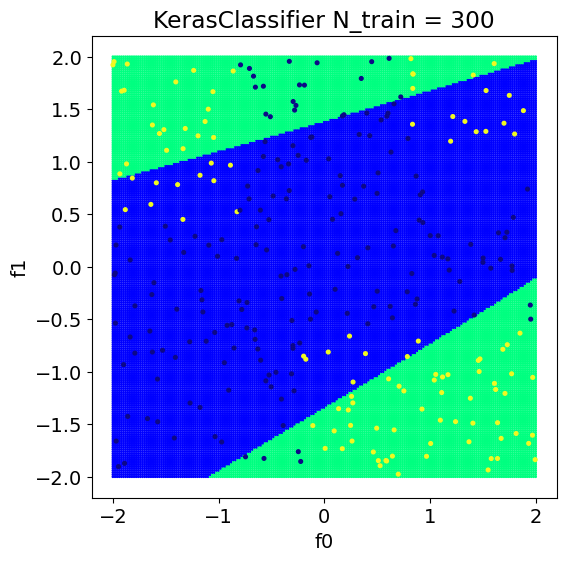

7/7 [==============================] - 0s 3ms/step
errors: 2.50%
1263/1263 [==============================] - 4s 3ms/step


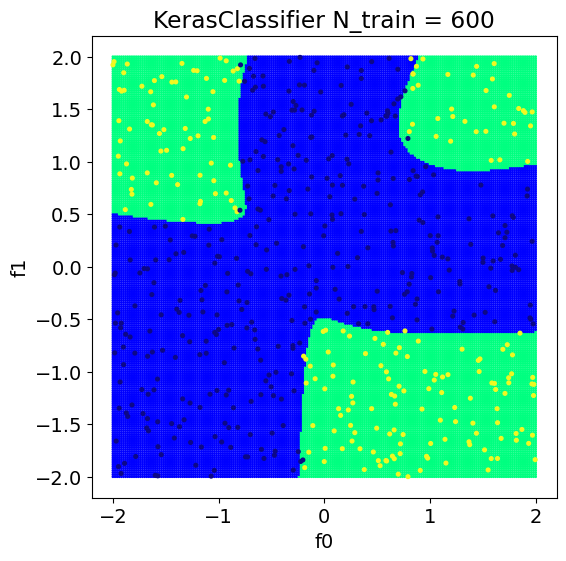

7/7 [==============================] - 0s 3ms/step
errors: 9.50%
1263/1263 [==============================] - 3s 3ms/step


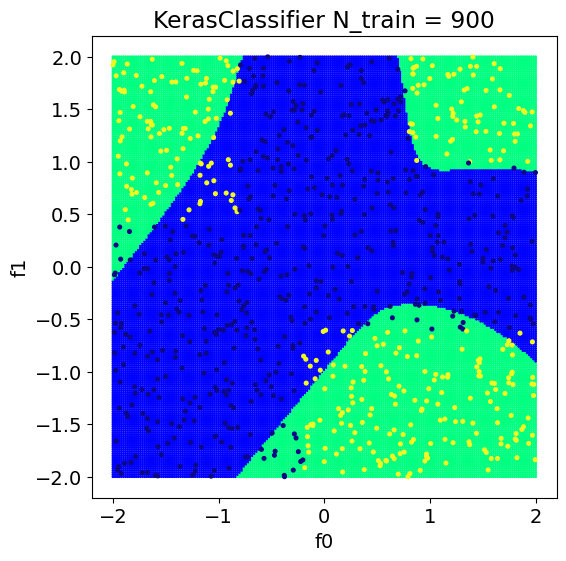

7/7 [==============================] - 0s 3ms/step
errors: 3.50%
1263/1263 [==============================] - 3s 2ms/step


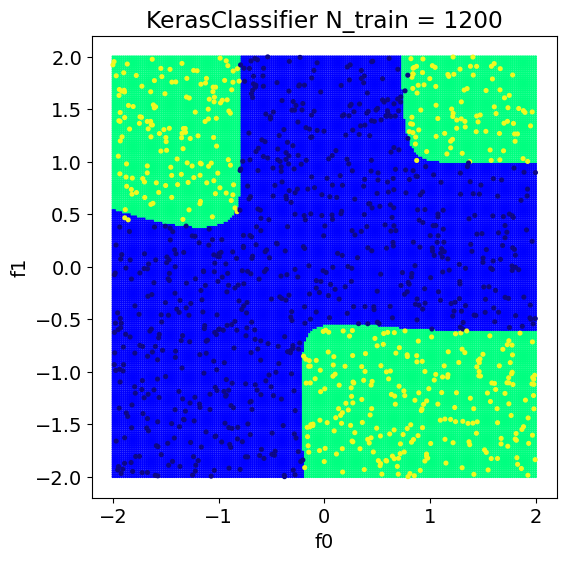

7/7 [==============================] - 0s 4ms/step
errors: 2.50%
1263/1263 [==============================] - 3s 3ms/step


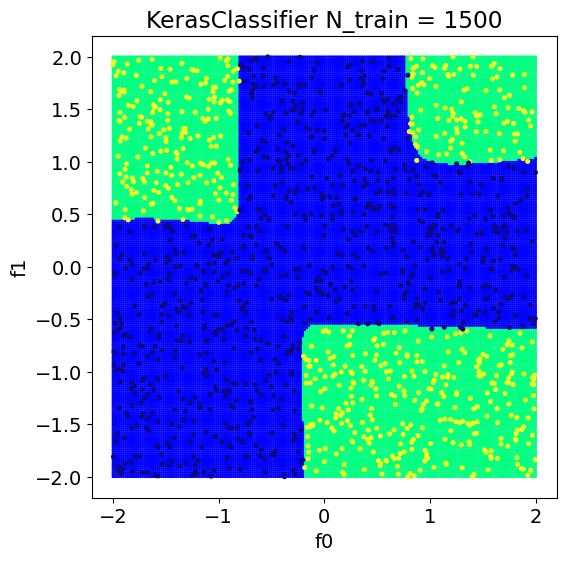

7/7 [==============================] - 0s 5ms/step
errors: 1.00%
1263/1263 [==============================] - 3s 3ms/step


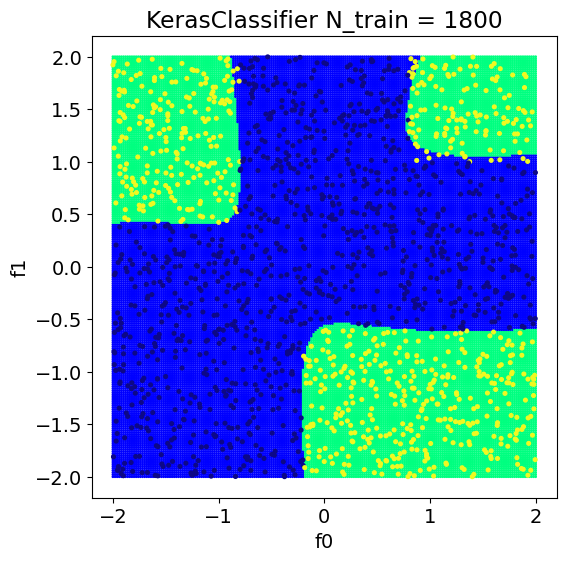

In [8]:
def create_model(activation="relu"):                # model takes as input activation function; will be optimized using gridsearchCV
    model = Sequential()                            # start sequential list of layers
    model.add(Dense(L, input_shape=(L,), activation=activation))
    model.add(Dense(20, activation=activation))
    model.add(Dense(20, activation=activation))
    model.add(Dense(20, activation=activation))
    model.add(Dropout(0.01))                        # the Dropout is added only to the previous layer
    model.add(Dense(1, activation='sigmoid'))       # 1 to have one single output
    return model
    
# compile model function, as in Mehta
def compile_model(optimizer="Nadam", activation="elu"):
    model = create_model(activation)
    model.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
    return model

# model_NN = KerasClassifier(build_fn=compile_model, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)
errors_NN = []
for i in range(300, N_train+300, 300):
    # model_results = model_NN.fit(x_train[:i], y_train[:i])
    err = classify(KerasClassifier(build_fn=compile_model, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0),show=False, num=i)
    errors_NN.append(err)

errors: 3.50%


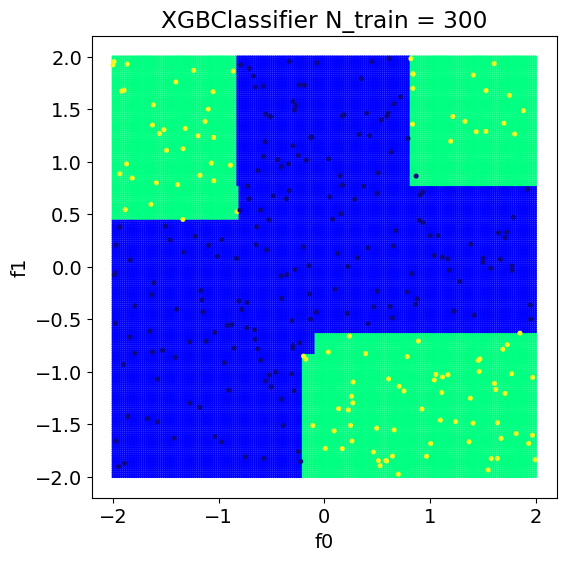

errors: 3.00%


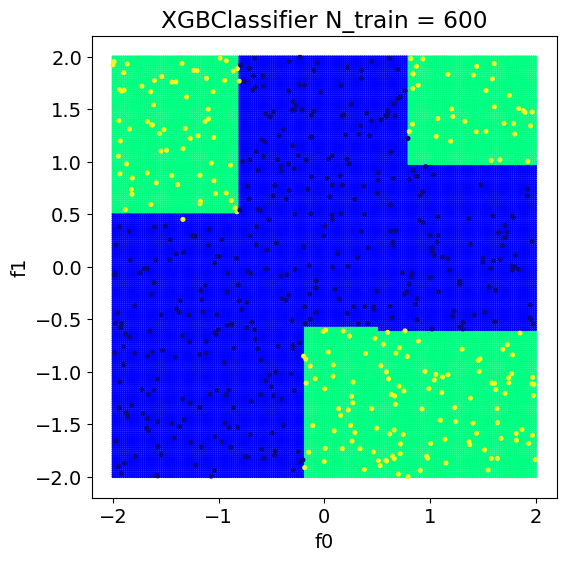

errors: 0.50%


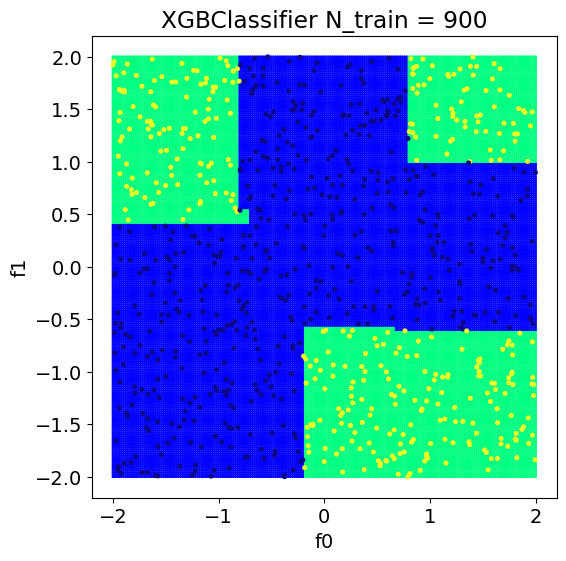

errors: 0.50%


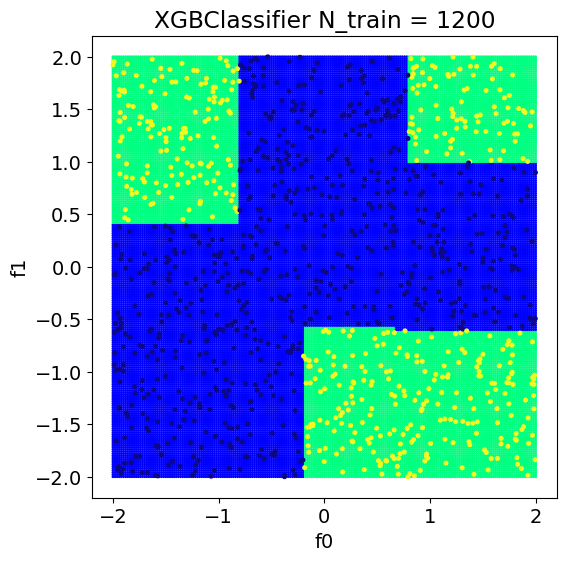

errors: 0.50%


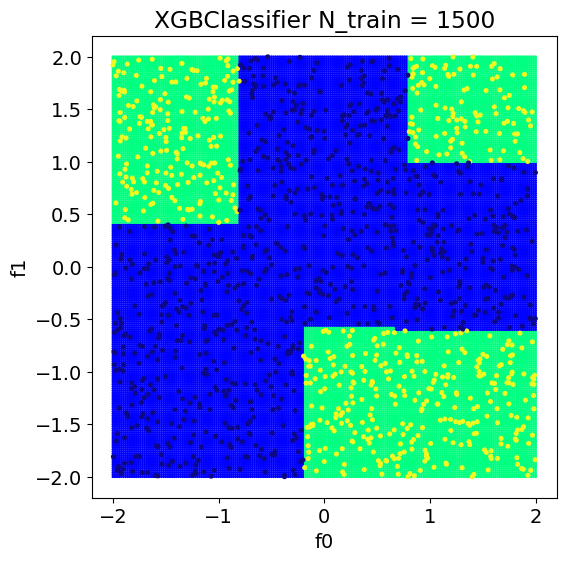

errors: 0.50%


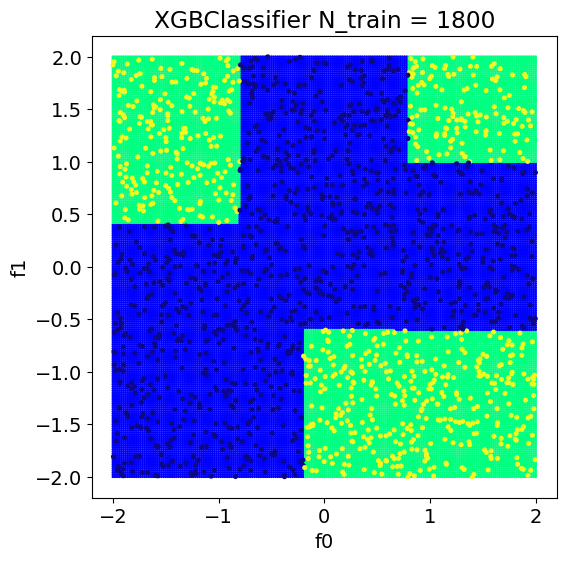

In [9]:
xgboost.set_config(verbosity=0)
errors_XGB = []
for i in range(300, N_train+300, 300):
    err = classify(XGBClassifier(learning_rate=0.4, objective='binary:logistic', reg_lambda=0.001, n_estimators=3), num=i)
    errors_XGB.append(err)

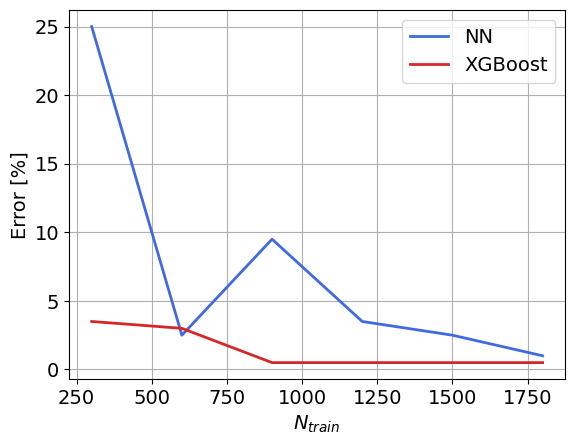

In [10]:
plt.plot(range(300, N_train+300, 300), errors_NN, color="royalblue", lw=2, label="NN")
plt.plot(range(300, N_train+300, 300), errors_XGB, color="tab:red", lw=2, label="XGBoost")
plt.grid()
plt.xlabel("$N_{train}$")
plt.ylabel("Error [%]")
plt.legend()
plt.show()

### We can see easily how XGBoost gives better results, even with a small training set size. At the same time, XGBoost is a more robust method.

# 2.
### We run a gridsearch over 4 hyperparams for the XGBoost: `gamma`, `lambda`, the `number of trees` (*n_estimators*) and the `learning rate` (eta). Now, we use CASE = 0, so the data set generated as in the first homework.

In [11]:
# CASE = 0
x_train, x_test, y_train, y_test, N_train = data(0)

In [12]:
# Gridsearch for the XGBoost
parameters = {  'gamma': [0.,1.,10.,100.,500.,1000.],
                'lambda': [100.,10.,1.,0.1,0.01, 0.001],
                'n_estimators': [3,15,30,45,80,100],
                'eta': [1., 0.3, 0.03]
                }

# xgboost.set_config(verbosity=0)
xgb = XGBClassifier(learning_rate=0.4, objective='binary:logistic')

grid = GridSearchCV(estimator=xgb, param_grid=parameters, n_jobs=1, cv=4)
grid_result = grid.fit(x_train, y_train)

In [13]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: 0.980000 using {'eta': 1.0, 'gamma': 0.0, 'lambda': 1.0, 'n_estimators': 45}


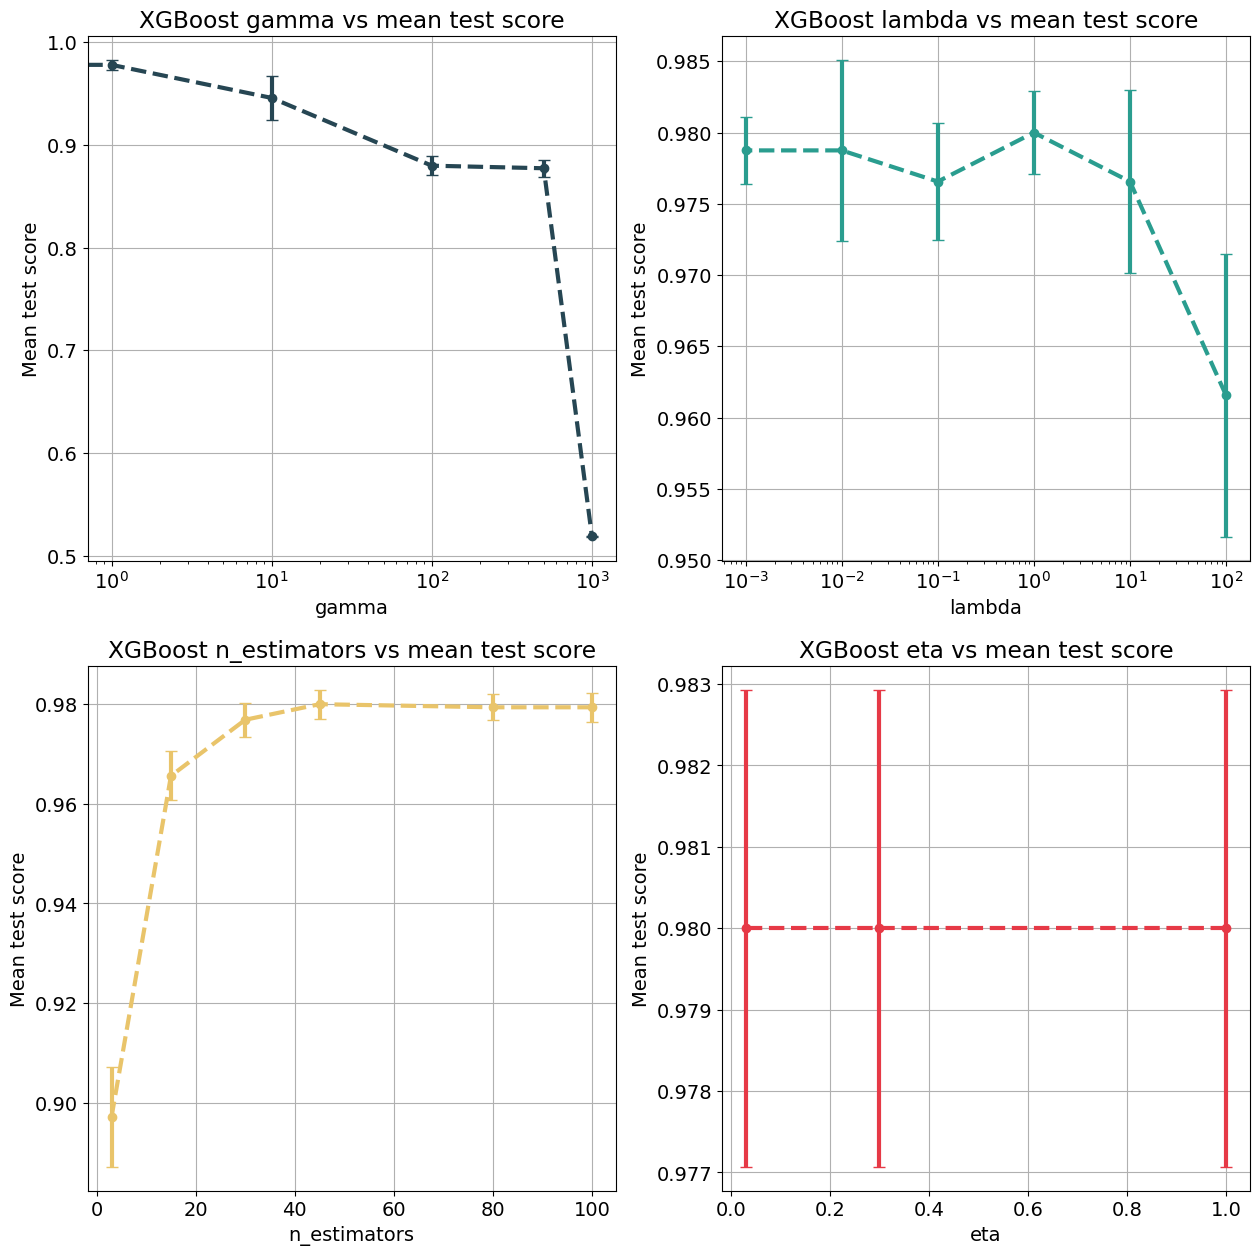

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

colors = ["#264653", "#2a9d8f", "#e9c46a", "#e63946"]

for i in range(2):
	for j in range(2):        
		selected_param = list(parameters.keys())[2*i+j]        
		res_y = []
		res_y_std= []
		new_param = list(parameters.keys())
		new_param.remove(selected_param)
		for mean, stdev, param in zip(means, stds, params):
			if [param[new_param[0]], param[new_param[1]], param[new_param[2]]] == [grid_result.best_params_[new_param[0]], grid_result.best_params_[new_param[1]], grid_result.best_params_[new_param[2]]]:
				res_y.append(mean)
				res_y_std.append(stdev)
		# ax[i, j]
		ax[i, j].errorbar(parameters[selected_param], res_y, yerr=res_y_std, color=colors[2*i+j], lw=3, fmt="o", ls="--", capsize=4)
		ax[i, j].set_title(f"XGBoost {selected_param} vs mean test score")
		ax[i, j].set_xlabel(selected_param)
		ax[i, j].set_ylabel('Mean test score')
		ax[i, j].grid()
		if i == 0: 
			ax[i, j].set_xscale('log') 
		# if i == 1 and j == 1: 
		# 	ax[i, j].set_xscale('log') 

errors: 1.50%


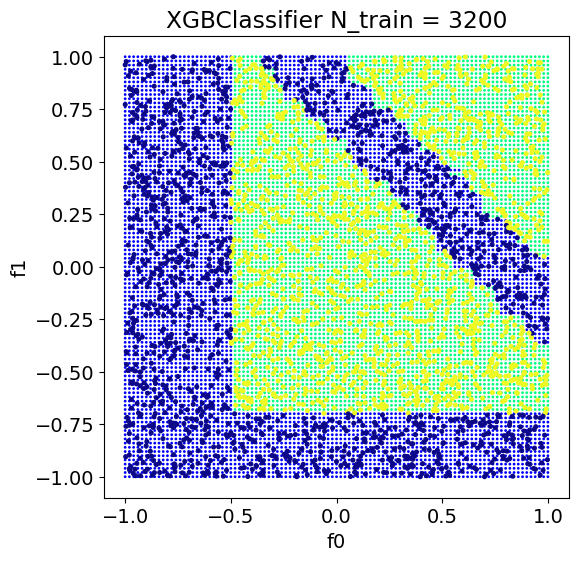

num_trees= 45


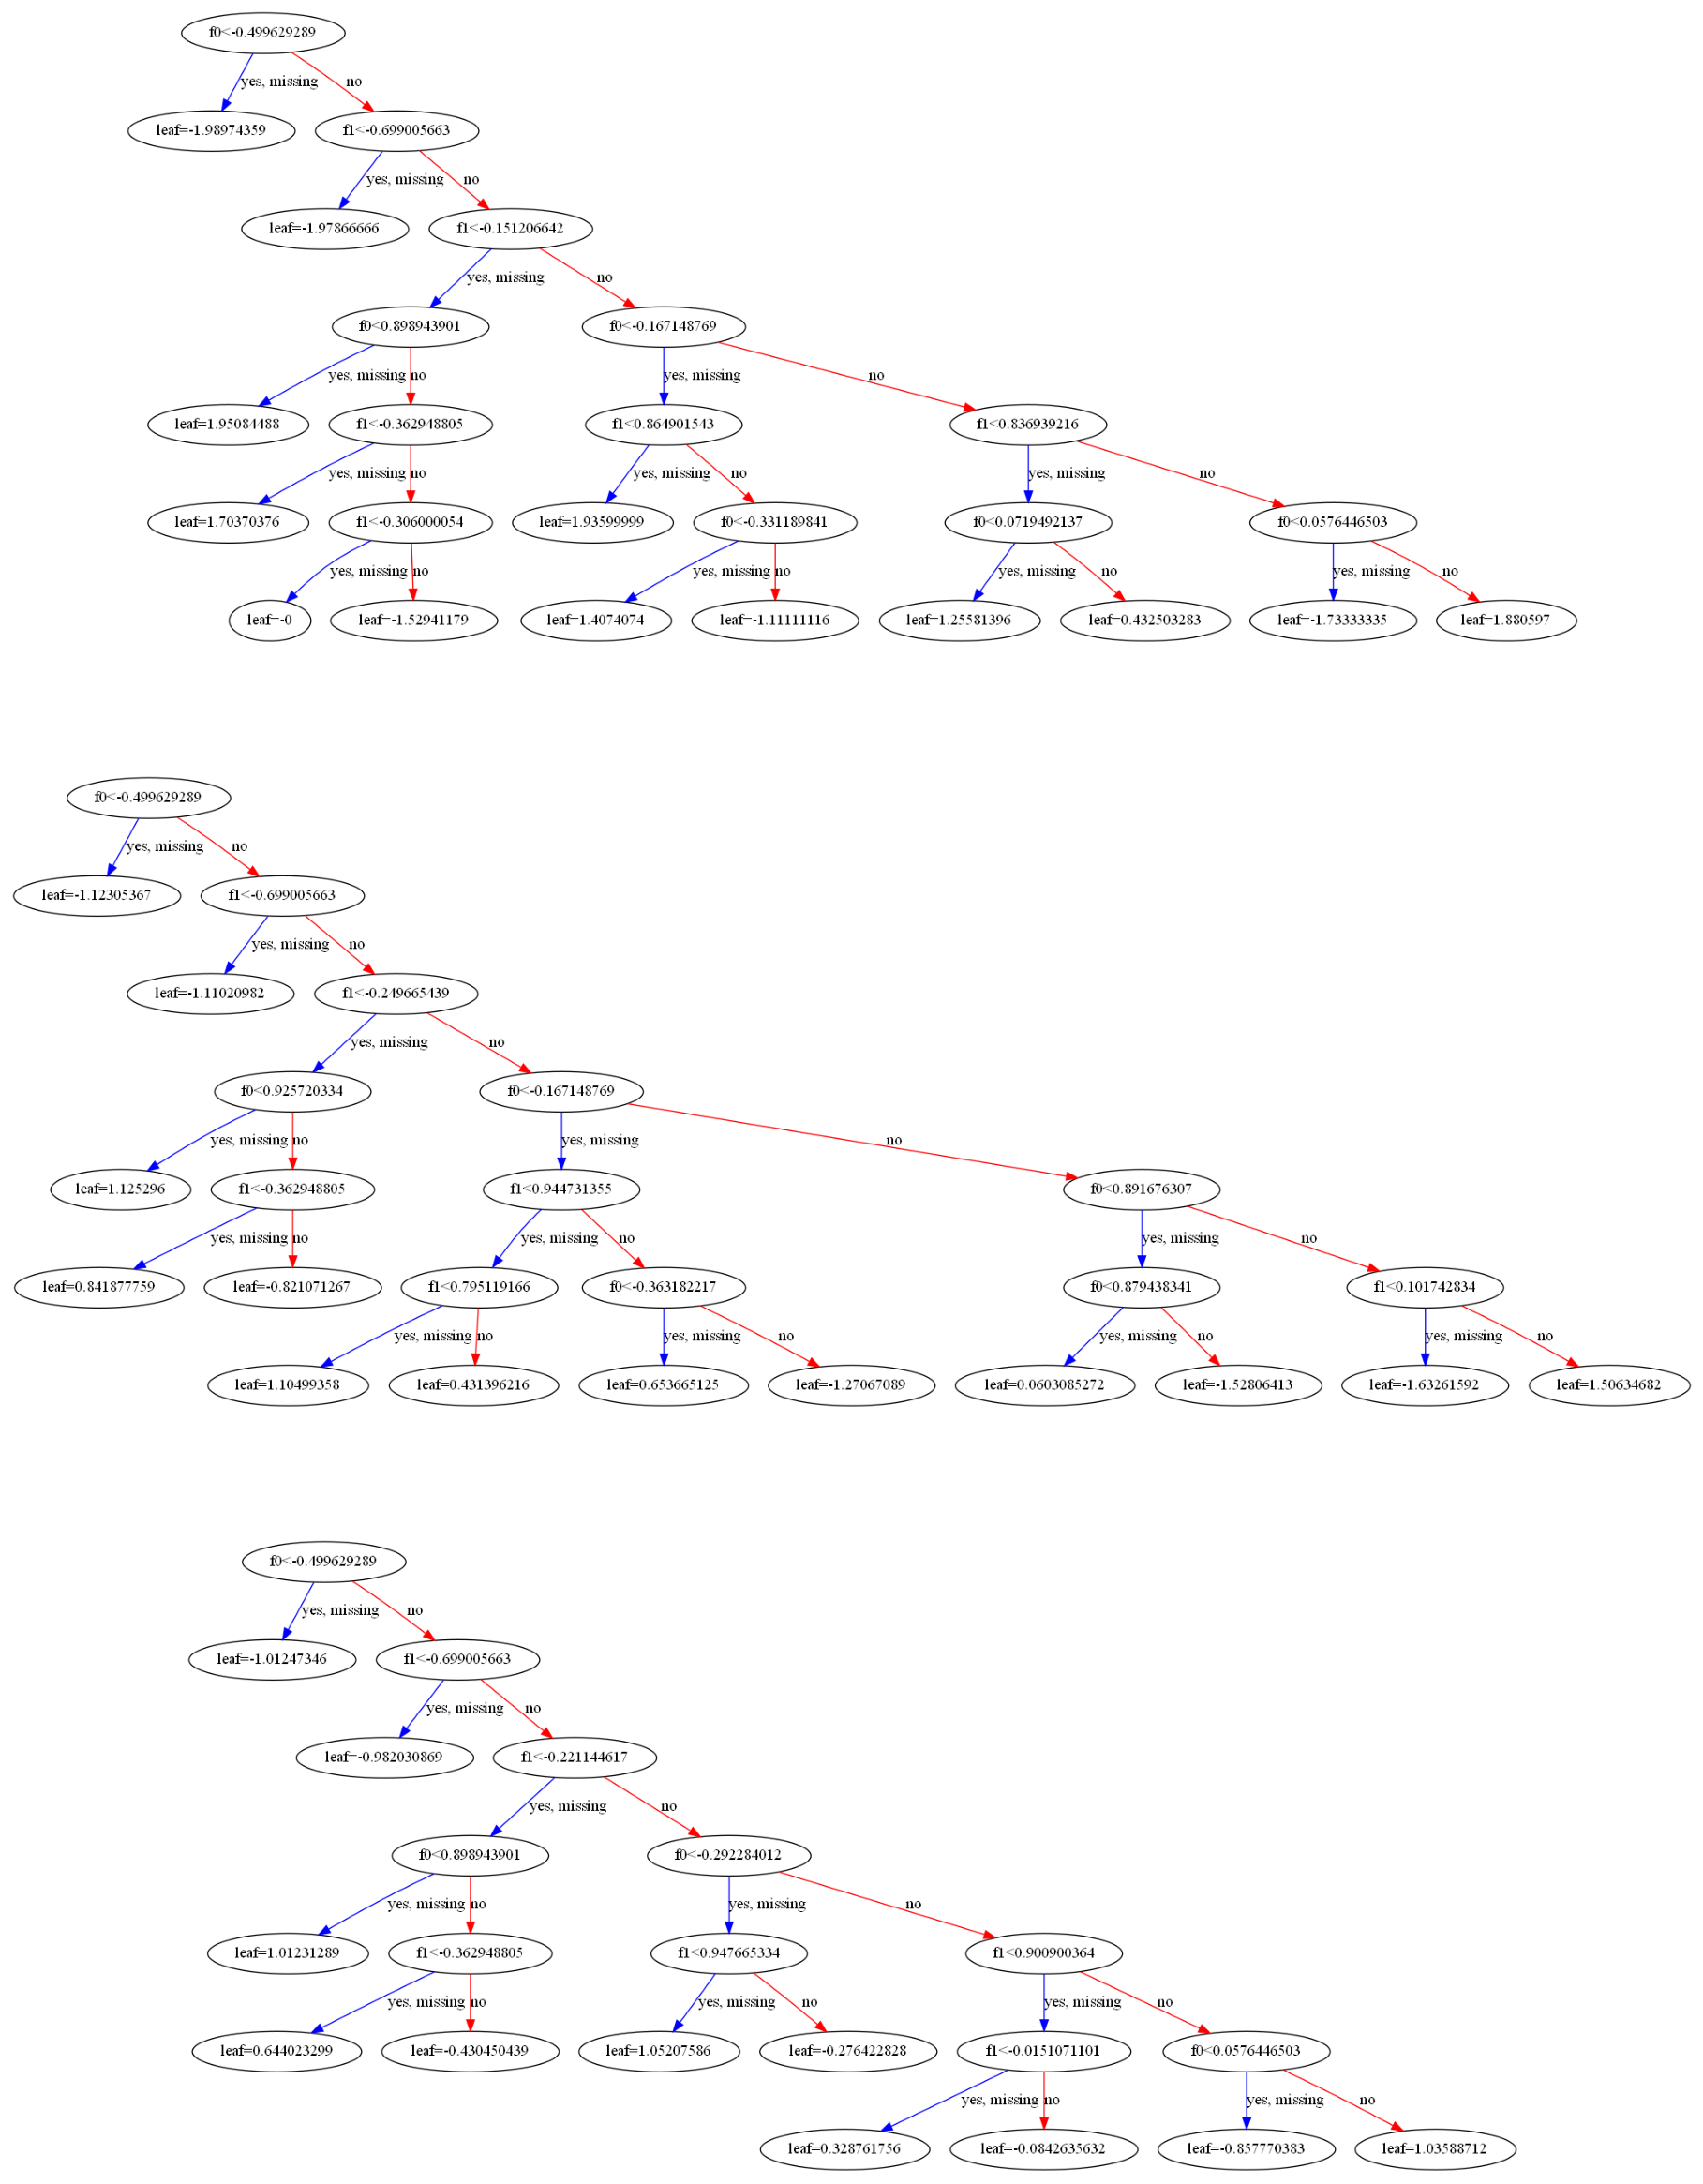

1.5000000000000013

In [15]:
# XGBClassifier with the best parameters found in the gridsearch
classify(XGBClassifier(objective = 'binary:logistic',
                       learning_rate = grid_result.best_params_['eta'],
                       gamma = grid_result.best_params_['gamma'],
                       n_estimators = grid_result.best_params_['n_estimators'],
                       reg_lambda = grid_result.best_params_['lambda']), show=True, CASE=0, num=N_train)

C:\Users\ricta\AppData\Local\Temp\ipykernel_27608\2672995151.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classify(KerasClassifier(build_fn=compile_model, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0),show=False, CASE=0, num=N_train)


25/25 [==============================] - 0s 3ms/step
errors: 0.75%
319/319 [==============================] - 1s 3ms/step


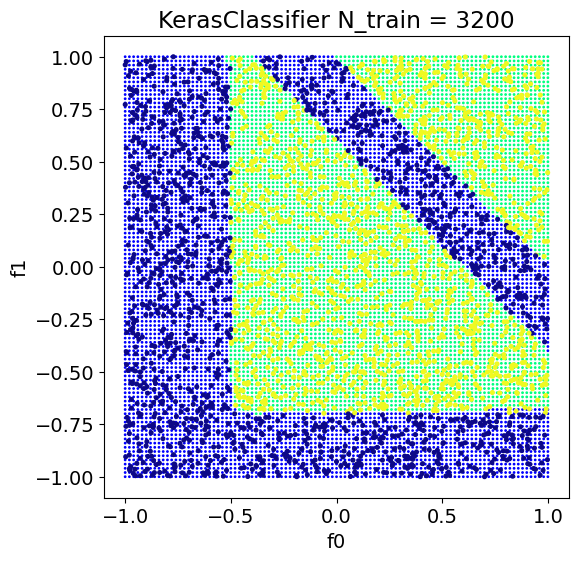

0.7499992847442627

In [17]:
# KerasClassifier with the chosen parameters
classify(KerasClassifier(build_fn=compile_model, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0),show=False, CASE=0, num=N_train)

### Keras with the best fit parameters gives back a nearly perfect error value of ~$1\%$. XGBooster performs better, with this data set, when the number of trees is higher. 
### The simplest yet effective XGBooster model is obtained with small regularization constrains ($\gamma$ and $\lambda$). At the same time, we notice that a larger number of trees (more that $10$) gives a score of ~$95\%$, reaching a scoring plateau after ~$40$ trees. 